# Sample Workflow: Alveo

This worksheet pulls data from the Alveo API and performs some NER using Spacy.

In [3]:
!pip install -q -r requirements.txt

In [2]:
import spacy
import csv
import geocoder
import pandas as pd
import re
import utils
import pyalveo

Alveo requires a login and uses an API key to validate user requests. We read this from the file `secret.json`.  

The data we will work with is represented by an [item list](http://alveo.edu.au/documentation/discovering-and-searching-the-collections/saving-your-search-results-to-an-item-list/) in Alveo - this is a list of items selected via a query as the starting point for a research project.   In this case I've selected three items from the [Braided Channels](https://app.alveo.edu.au/catalog/braidedchannels) collection that contains transcripts of oral history interviews.  Each item list has a URL and we refer to that here. 

In [3]:
API_KEY = utils.secret('alveo')
API_URL = "https://app.alveo.edu.au/"
item_list_url = "https://app.alveo.edu.au/item_lists/1387"

We create an API client with the pyalveo module and use the client to get the item list details.  We then get the _primary text_ for each item.  We store these in a python list of texts.

In [4]:
client  =  pyalveo.Client(api_key=API_KEY, api_url=API_URL)
itemlist = client.get_item_list(item_list_url)

print("Item list name: ", itemlist.name())

texts = []
for itemurl in itemlist:
    item = client.get_item(itemurl)
    text = item.get_primary_text()
    text = text.decode() # convert from bytes to a string
    text = re.sub('\W+', ' ', text)
    texts.append(text) 

print("Got", len(texts), "texts")

Item list name:  braided-sample
Got 3 texts


## NER Using Spacy

We will use Spacy to extract Named Entities from the text.   We download the appropriate models and initialise an NLP processor. 

In [5]:
# download the spacy models we need
model = 'en_core_web_md'
spacy.cli.download(model)
nlp = spacy.load(model)


    Linking successful
    /opt/conda/lib/python3.6/site-packages/en_core_web_md -->
    /opt/conda/lib/python3.6/site-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



We then extract entities from the texts.  The results will be converted to a Pandas data frame. In this example we retain all of the entity types in the result and for each result include a _context_ string showing the words each side of the entity that was found. 

In [6]:
places = []

for text in texts:
    doc = nlp(text)
    for ent in doc.ents:
        context = doc[ent.start-2:ent.end+3]
        context = " ".join([w.text for w in context])
        d = {'label': ent.label_, 'text': ent.text, 'context': context}
        places.append(d)

entities = pd.DataFrame(places)
print("Found ", entities.shape[0], "entities in the texts")
entities.head()

Found  578 entities in the texts


,context,label,text
0,,CARDINAL,1
1,A from 10_BC_DV This is DAT,CARDINAL,10_BC_DV
2,It s 4 June 2000 Trish FitzSimons sound,DATE,4 June 2000
3,June 2000 Trish FitzSimons sound recording,NORP,Trish
4,2000 Trish FitzSimons sound recording Erica,ORG,FitzSimons


We might be particularly interested in the GPE entities - locations.  We can select these as follows

In [8]:
locations = entities[entities['label'] == 'GPE']
locations.head()

,context,label,text
12,born in Brisbane in February 1954,GPE,Brisbane
24,up in Brisbane and we had,GPE,Brisbane
26,south of Boulia and that was,GPE,Boulia
40,out to Alexandria in the Northern,GPE,Alexandria
44,lot of Australia you ve Yes,GPE,Australia


We can then plot the frequency of occurence of each place name in the texts. 

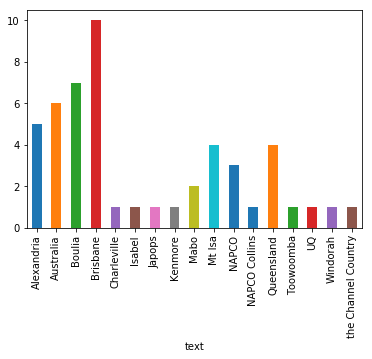

In [9]:
% matplotlib inline
grouped = locations.groupby('text')
counts = grouped.size()
counts.plot.bar()